In [1]:
import sys
sys.path.append('./module')
from kalman_filters import EnKalmanFilter
from date_time import datetime_array

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

## データ取得
### データダウンロード

In [2]:
import urllib

json_url = 'https://data.corona.go.jp/converted-json/covid19japan-npatients.json'
path_for_save = 'json/covid19japan-npatients.json'
urllib.request.urlretrieve(json_url, path_for_save)

df = pd.read_json(path_for_save)

 ### データ観察

<BarContainer object of 57 artists>

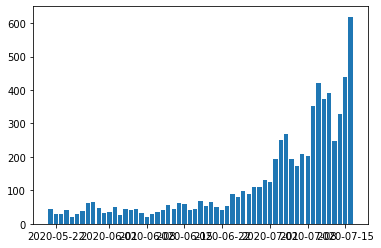

In [3]:
X = df['npatients']
Y = df['adpatients']
date = df['date']
fig1, ax1 = plt.subplots()
ax1.bar(date.iloc[30:], Y.iloc[30:])

## EnKFで推定

In [4]:
# (x, mu)
# x = x0*exp(mu*t)を仮定
# todo: 初期値x0も推定する．

# モデル誤差
q = 1e-5
# 観測誤差
r  = 1e3

# 追加推定期間
additional_days = 7


#  観測
H = lambda x : x[0]
R = r*np.identity(1)

# 状態遷移
M = lambda x, dt : np.array([x[0]*(1+x[1]*dt), x[1]])
Q = q*np.identity(2)

In [5]:
def estimate_and_plot(t, y, q, r, additional_days, label):
#     H, R, M, Qに依存
# 初期値
    x_0 = np.array([y[0], 0.1])
    P_0 = 1e6*np.identity(2)

#     推定
    enkf = EnKalmanFilter(M, H, Q, R, y, x_0, P_0, N=10, dt=1)
    enkf.forwardEstimation(verbose=False)

    enkf.additional_forecast(additional_days)

    result = np.array(enkf.x_log)
    
#     muをplot
    mu = result[-1][1]
    print('mu: {}'.format(mu))

    fig, ax2 = plt.subplots(figsize=(10,10))
    ax2.plot(t, result[:-1*additional_days,1], label='est_mu', alpha=0.3, color='r')
    plt.title('mu estimation of {}'.format(label))
    ax2.legend()
    
#     推定結果をplot
    date_array = datetime_array(t[-1*additional_days], 2*additional_days)

    # plot 
    fig, ax3 = plt.subplots(figsize=(10,10))
    ax3.plot(t, result[:-1*additional_days,0], label='estimation', alpha=0.3, color='r')
    ax3.bar(date_array, result[-2*additional_days:,0], label='additional forecast')
    ax3.bar(t, y,label='observation', alpha=0.3, color='b')
    plt.title('estimation of {}'.format(label))
    ax3.legend()
    

### 累積感染者数

mu: 0.023608120797806956


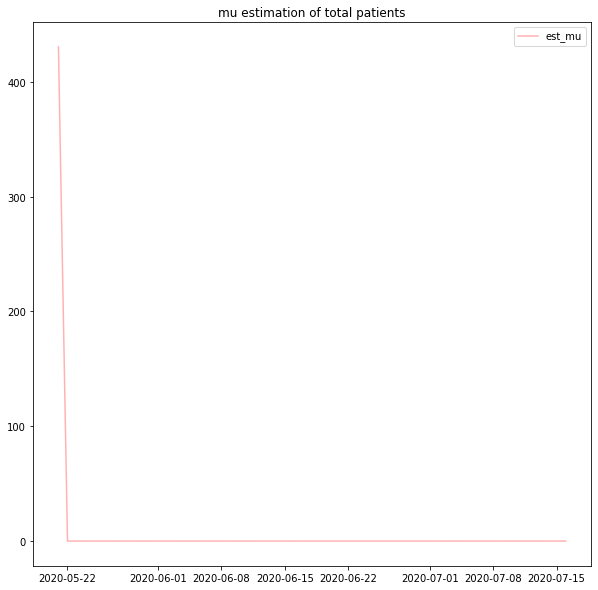

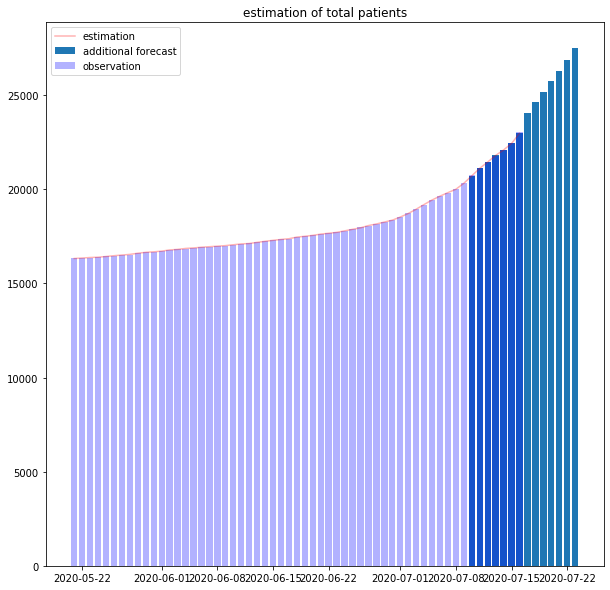

In [6]:
t = np.array(date.iloc[30:])
y_total = np.array(X.iloc[30:])
estimate_and_plot(t, y_total, q, r, additional_days, 'total patients')

### 新規感染者数

mu: 0.09039293324869527


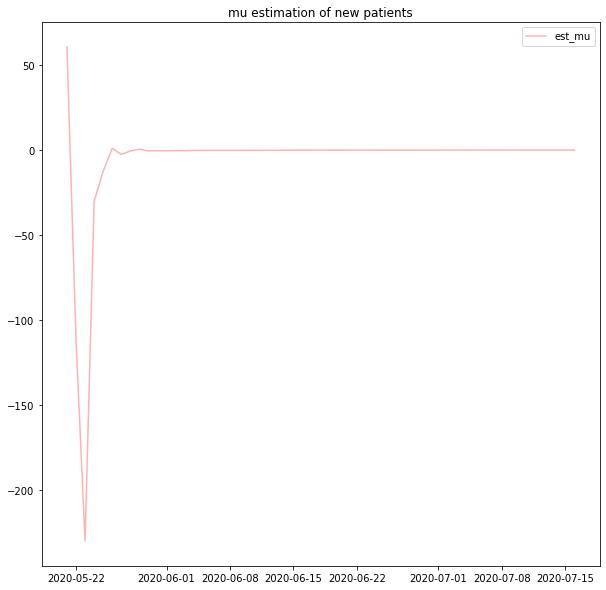

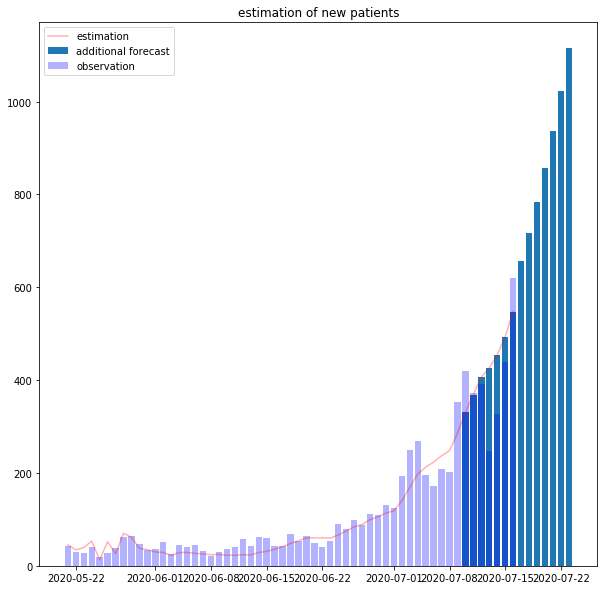

In [7]:
# データをとってくる
t = np.array(date.iloc[30:])
y_new = np.array(Y.iloc[30:])
estimate_and_plot(t, y_new, q, r, additional_days, 'new patients')